<a href="https://colab.research.google.com/github/DanieleAngioni97/CV_Project/blob/main/Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# **Data Preparation**

In [1]:
import pandas as pd
from sklearn.utils import shuffle

MAIN_PATH = "/content/drive/My Drive/Colab_Notebooks/CV_Project"

df_train = pd.read_csv(MAIN_PATH + "/training_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_train = df_train[['filename','x', 'y', 'u', 'v']]
df_validation = pd.read_csv(MAIN_PATH + "/validation_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_validation = df_validation[['filename','x', 'y', 'u', 'v']]

df_dataset = pd.concat([df_train, df_validation], ignore_index = True)

df_dataset = shuffle(df_dataset)
df_dataset = pd.concat([df_dataset], ignore_index = True)

#EXECUTE ONLY ONE TIME
df_dataset.to_csv(MAIN_PATH + "/dataset.csv", index = False)

print(df_dataset)

           filename          x         y         u         v
0      4L043380.jpg  -7.020114 -0.503754  0.016899  0.999857
1      2L043600.jpg  -8.190838 -7.037955  0.079262  0.996854
2      6L043900.jpg  -9.679928  0.855329  0.085251 -0.996332
3      8L073880.jpg   4.803946 -7.870023  0.999591 -0.028564
4      4L025320.jpg  19.150197  0.974447 -0.678845  0.732544
...             ...        ...       ...       ...       ...
13355  4L035800.jpg  -1.036940 -4.222020 -0.999523  0.030883
13356  8L016660.jpg -12.156101 -6.188729 -0.998969 -0.045342
13357    053500.jpg  -3.413085  6.068778 -0.996315 -0.085585
13358  8L012720.jpg -18.849415  4.156326 -0.806388 -0.590948
13359  4L042920.jpg  -7.127669 -0.821350 -0.137418  0.990503

[13360 rows x 5 columns]


In [2]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

MAIN_PATH = "/content/drive/My Drive/Colab_Notebooks/CV_Project"
values_to_predict = ['x', 'y', 'u', 'v']
IMG_SIZE = 128
BATCH_SIZE = 512

validation_size = 0.1

df_train = pd.read_csv(MAIN_PATH + "/training_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_train = df_train[['filename','x', 'y', 'u', 'v']]
train_len = df_train.shape[0]
df_validation = df_train[int(train_len*(1-validation_size)):]
df_train = df_train[:int(train_len*(1-validation_size))]

print("Loading train data ...")
train_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
train_dataset = train_dataset.flow_from_dataframe(
    dataframe = df_train,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "raw")

print("\nLoading validation data ...")
validation_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
validation_dataset = validation_dataset.flow_from_dataframe(
    dataframe = df_validation,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=False,
    class_mode = "raw")

print("\nLoading test data ...")
df_test = pd.read_csv(MAIN_PATH + "/validation_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_test = df_test[['filename','x', 'y', 'u', 'v']]
test_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
test_dataset = test_dataset.flow_from_dataframe(
    dataframe = df_test,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = values_to_predict,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=False,
    class_mode = "raw")

Loading train data ...
Found 9233 validated image filenames.

Loading validation data ...
Found 1026 validated image filenames.

Loading test data ...
Found 3101 validated image filenames.


# **Visualizing some images**

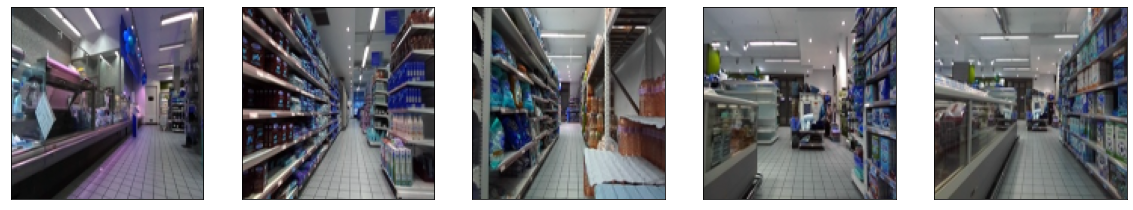

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow #used because cv2.imshow get crushed in colab

N_IMAGES = 5    #number of images to be visualized

train = df_train.to_numpy()
files_train = train[:,0]
np.random.shuffle(files_train)


x_train = np.zeros((N_IMAGES, IMG_SIZE, IMG_SIZE, 3))


for i,file_name in enumerate(files_train[:N_IMAGES]):
    img = cv2.imread(MAIN_PATH + "/images/" + file_name)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x_train[i,:,:,:] = img/255
  
  
plt.figure(figsize=(20, 10))
for i in range(N_IMAGES):
    ax = plt.subplot(2, N_IMAGES, i+1)
    plt.imshow(x_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()


# **Define model's architecture**

In [4]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

model = Sequential([
            Conv2D(16, (3,3), activation = 'relu', padding='same',
                input_shape = (IMG_SIZE,IMG_SIZE,3)),
            MaxPooling2D((2, 2), padding='same'),#64x64x16
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#32x32x32
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#16x16x64
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2), padding='same'),#32x32x128
            Flatten(),
            Dense(128, activation='relu'),
            Dense(4)                                       
        ])

model.summary()

optim = Adam(learning_rate=0.001)
loss = MeanSquaredError()
model.compile(optimizer=optim, loss=loss)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       7

# **Train the model**

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from keras.models import load_model
print("Loading model ...")
model = load_model(MAIN_PATH + "/saved_models/2nd_round_weights-improvement-04-2.320438.hdf5")
print("Model loaded.")

filepath = "/content/drive/My Drive/Colab_Notebooks/CV_Project/"
filepath_models = filepath + "saved_models/3nd_round_weights-improvement-{epoch:02d}-{val_loss:2f}.hdf5"
filepath_csv = filepath + "loss/my_logs_new.csv"

checkpoint = ModelCheckpoint(filepath_models, monitor="val_loss", verbose=1, 
                             save_best_only=True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", min_delta = 0.01, 
                           patience = 5, verbose = 1)
log_csv = CSVLogger(filepath_csv, separator=',', append=True)

callbacks_list = [checkpoint, log_csv]

history = model.fit(train_dataset,
                    epochs=50,
                    steps_per_epoch = df_train.shape[0]/BATCH_SIZE,
                    validation_steps = df_validation.shape[0]/BATCH_SIZE,
                    verbose=1,
                    validation_data = validation_dataset,
                    callbacks = callbacks_list,
                    workers = 8)

Loading model ...
Model loaded.
Epoch 1/50
19/18 [===============================] - ETA: 0s - loss: 1.1986
Epoch 00001: val_loss improved from inf to 2.39332, saving model to /content/drive/My Drive/Colab_Notebooks/CV_Project/saved_models/3nd_round_weights-improvement-01-2.393318.hdf5
19/18 [===============================] - 18s 951ms/step - loss: 1.1986 - val_loss: 2.3933
Epoch 2/50
19/18 [===============================] - ETA: 0s - loss: 1.1621
Epoch 00002: val_loss improved from 2.39332 to 2.38613, saving model to /content/drive/My Drive/Colab_Notebooks/CV_Project/saved_models/3nd_round_weights-improvement-02-2.386132.hdf5
19/18 [===============================] - 15s 793ms/step - loss: 1.1621 - val_loss: 2.3861
Epoch 3/50
19/18 [===============================] - ETA: 0s - loss: 1.0800
Epoch 00003: val_loss did not improve from 2.38613
19/18 [===============================] - 15s 779ms/step - loss: 1.0800 - val_loss: 2.3930
Epoch 4/50
19/18 [===============================] - E

# **Visualize loss landscape**

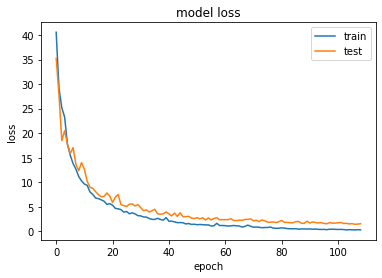

Minimum validation loss reached :  1.5495438575744631


In [14]:
import matplotlib.pyplot as plt

training_log = pd.read_csv("/content/drive/My Drive/Colab_Notebooks/CV_Project/loss/my_logs_new.csv").to_numpy()

loss = training_log[:,1]
val_loss = training_log[:,2]

#summarize history for loss
plt.figure()
plt.plot(list(loss))
plt.plot(list(val_loss))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig("/content/drive/My Drive/Colab_Notebooks/CV_Project/loss/" + 'bestmodel-LOSS_30-10.png')
plt.show()

print("Minimum validation loss reached : ", val_loss[-1])

# **Compute predictions**

In [19]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import numpy as np
import math  

print("Loading model ...")
model = load_model(MAIN_PATH + "/saved_models/3nd_round_weights-improvement-48-1.443783.hdf5")
print("Model loaded.")

print("\nStarting predicting ...")
predicted = model.predict(test_dataset, batch_size = 1024)
np.savetxt(MAIN_PATH + "/predictions/predictions.csv", predicted, delimiter=",")

target = df_test.to_numpy()[:,1:]
print("Prediction's done.")

Loading model ...
Model loaded.

Starting predicting ...
Prediction's done.


# **Compute mean and median errors**

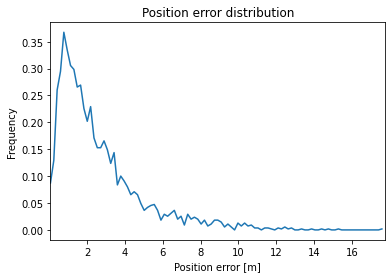

Mean Location Error: 2.6564 m
Median Location Error: 1.9871 m


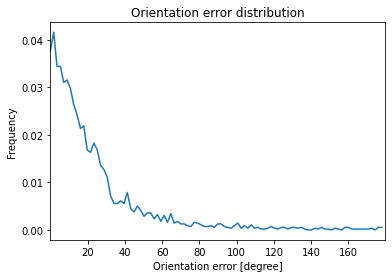

Mean Orientation Error: 23.4721 °
Median Orientation Error: 15.1776 °


In [20]:
import matplotlib.pyplot as plt

predicted = pd.read_csv(MAIN_PATH + "/predictions/predictions.csv", names=['x', 'y', 'u', 'v']).to_numpy()

def normalize(x):
    return x/(np.sqrt((x**2).sum(1).tolist())).reshape(-1,1)

position_errors = np.sqrt(((predicted[:,:2]-target[:,:2])**2).sum(1).tolist()) #OK

#ensure each x vector has norm=1
predicted_orientations = normalize(predicted[:,2:]) #OK
target_orientations = normalize(target[:,2:]) #OK
cosines = (predicted_orientations*target_orientations).sum(1)

for i, el in enumerate(cosines):
    if(abs(el)>1): 
        cosines[i] = np.sign(el)

orientation_errors = np.degrees(np.arccos(cosines.tolist()))
 
errors = [position_errors.mean(), np.median(position_errors), np.mean(orientation_errors), np.median(orientation_errors)]

loc_hist,  loc_bin = np.histogram(position_errors, bins = 100, density = True)
plt.figure()
plt.plot(loc_bin[:-1], loc_hist)
plt.xlim(min(loc_bin), max(loc_bin))
plt.title('Position error distribution')
plt.ylabel('Frequency')
plt.xlabel('Position error [m]')
plt.show()
print("Mean Location Error: %0.4f m" % (errors[0],))
print("Median Location Error: %0.4f m" % (errors[1],))

orient_hist,  orient_bin = np.histogram(orientation_errors, bins = 100, density = True)
plt.figure()
plt.plot(orient_bin[:-1], orient_hist)
plt.xlim(min(orient_bin), max(orient_bin))
plt.title('Orientation error distribution')
plt.ylabel('Frequency')
plt.xlabel('Orientation error [degree]')
plt.show()
print("Mean Orientation Error: %0.4f °" % (errors[2],))
print("Median Orientation Error: %0.4f °" % (errors[3],))